<a href="https://colab.research.google.com/github/EmreYuceSF/SfCrimePrediction/blob/main/preprocessing_and_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Importing libraries for data processing,
# visualization, machine learning,
# and Google Drive access
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import os
import scipy.stats as stats
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import json
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, silhouette_score
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances
from statsmodels.graphics.tsaplots import plot_acf
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
# Loading preprocessed crime data and setting 'incident_date' as the datetime index
df = pd.read_csv('./drive/MyDrive/Colab Notebooks/sf_crime_preprocessed.csv')
with open('./drive/MyDrive/Colab Notebooks/pre_processed_dtypes.json') as f:
    data_types = json.load(f)
df = df.astype(data_types)
df.set_index('incident_date', inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,incident_time,incident_year,incident_day,incident_no,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger,is_holiday,holiday_type
incident_date,,,,,,,,,,,,,,,,,
2018-01-01,00:55,2018,Monday,180000172,Assault,Simple Assault,Battery,Mission,37.768473,-122.405828,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day
2018-01-01,16:30,2018,Monday,186000005,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Mission,37.761268,-122.416797,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day
2018-01-01,19:30,2018,Monday,186017113,Lost Property,Lost Property,Lost Property,Financial District/South Beach,37.789241,-122.400722,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day
2018-01-01,19:00,2018,Monday,180002225,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Russian Hill,37.802201,-122.417966,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day
2018-01-01,22:00,2018,Monday,180017064,Lost Property,Lost Property,Lost Property,Castro/Upper Market,37.760889,-122.435001,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day


In [14]:
top5_subcat = df.subcategory.value_counts().sort_values(ascending=False).index[:5].to_list()

In [15]:
# Adding a 'pride_day' column to mark Pride Day (last Sunday of June) for each year from 2018 to 2024
df['holiday_type'] = df['holiday_type'].astype('object')
from datetime import datetime, timedelta

def pride_day(year):
    # Pride Month is June
    pride_month = 6
    # Last Sunday of June
    last_june_date = datetime(year, pride_month, 30)

    # Check the day of the week (0 = Monday, 6 = Sunday)
    while last_june_date.weekday() != 6:  # 6 is Sunday
        last_june_date -= timedelta(days=1)

    return last_june_date
pride_days = []
for i in range(2018, 2025):
    pride_days.append(pride_day(i).date())
df['pride_day'] = 0
df.loc[df.index.isin(pride_days), 'pride_day'] = 1

In [16]:
df.loc[df['pride_day'] == 1, 'holiday_type'] = 'pride_day'

In [17]:
# Resampling the data to daily frequency and aggregating specific columns
df_days = df.resample('D').agg({'precipitation':'max', 'is_holiday':'first', 'min_temperature':'mean','holiday_type':'first'})
df_days.head()

,precipitation,is_holiday,min_temperature,holiday_type
incident_date,,,,
2018-01-01,0.00,True,48.0,New Year's Day
2018-01-02,0.00,False,52.0,None
2018-01-03,0.09,False,53.0,None
2018-01-04,0.06,False,53.0,None
2018-01-05,0.26,False,52.0,None


In [18]:
df_days.drop(columns=['is_holiday'], inplace= True)

In [19]:
# Categorizing precipitation levels and handling missing values in 'holiday_type'
bins = [-1, 0.01, 5, float('inf')]
labels = ['No Rain', 'Light Rain', 'Heavy Rain']
df_days['precipitation'] = pd.cut(df_days['precipitation'], bins=bins, labels=labels, include_lowest=True)
df_days['holiday_type'].fillna('no_holiday', inplace=True)
df_days['holiday_type'] = df_days['holiday_type'].astype('category')

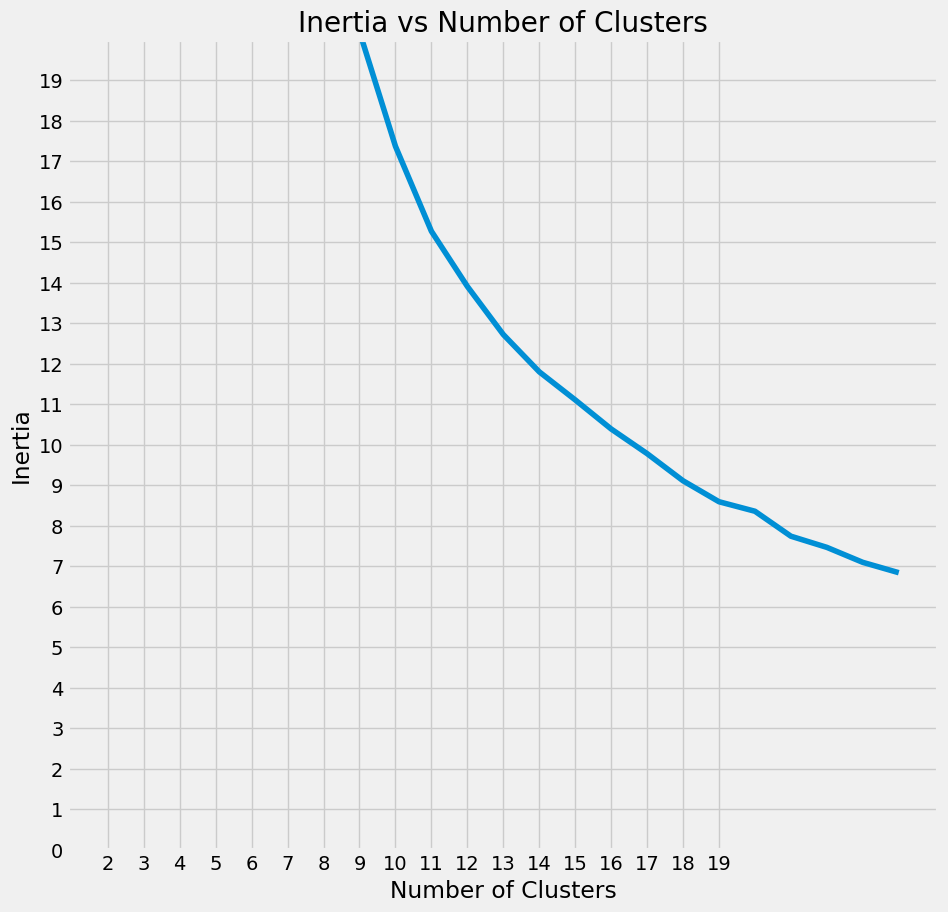

In [20]:
# Applying KMeans clustering to identify optimal number of clusters for vehicle-related crime data
df_cat_vehicle = df[df['subcategory'] ==  'Larceny - From Vehicle']
inertia = []
for i in range(2, 25):
    kmeans = KMeans(n_clusters=i, random_state=0, n_init=10).fit(df_cat_vehicle[['latitude', 'longitude']])
    inertia.append(kmeans.inertia_)
plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,10))
plt.plot(range(2, 25), inertia)
plt.xticks(range(2, 20))
plt.yticks(range(0, 20))
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia vs Number of Clusters')
plt.ylim(0,20)
plt.show();

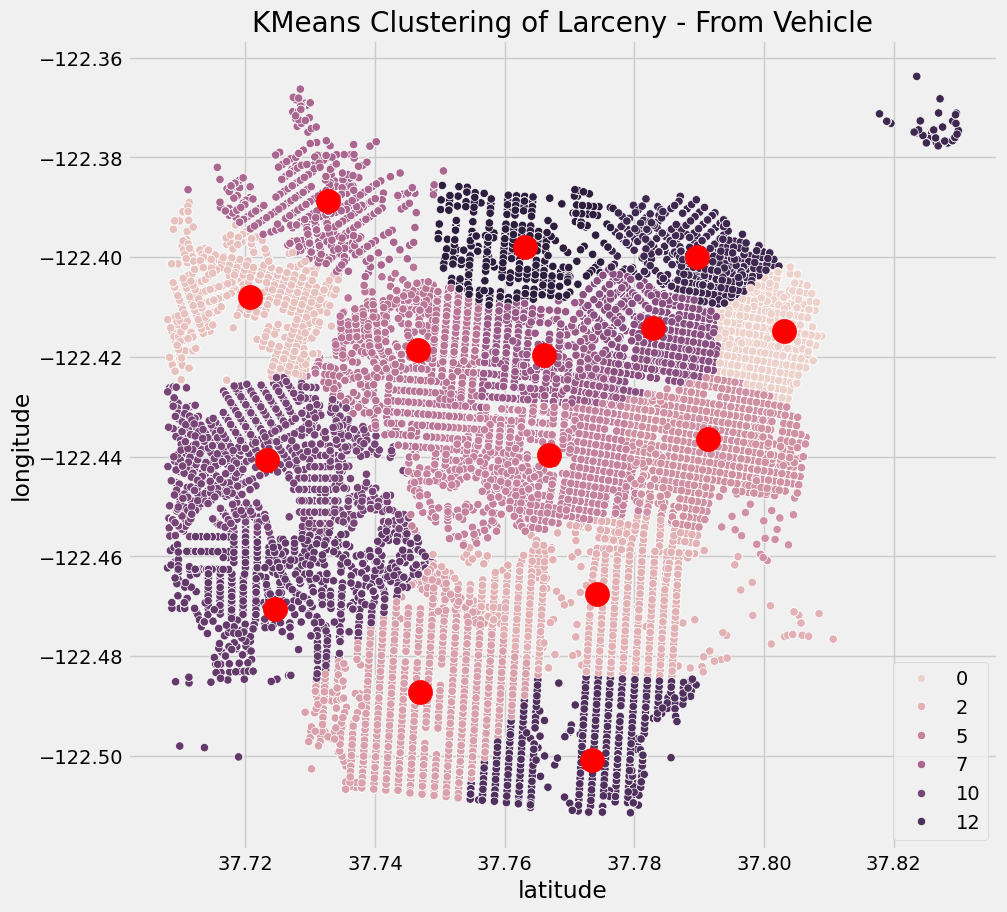

In [21]:
# Performing KMeans clustering with 15 clusters and visualizing the results on a scatter plot
kmeans = KMeans(n_clusters=15, random_state=0, n_init=10).fit(df[['latitude', 'longitude']])
plt.figure(figsize=(10,10))
sns.scatterplot(x='latitude', y='longitude', alpha=1, data=df, hue=kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.title('KMeans Clustering of Larceny - From Vehicle')
plt.show();

In [22]:
# Assigning neighborhood labels based on KMeans clustering and extracting incident hour from time
df['neighborhood_label'] = kmeans.predict(df[['latitude', 'longitude']])
df['incident_hour'] = df['incident_time'].apply(lambda x: int(x.split(':')[0]))


In [23]:
# Filtering and aggregating data for top 5 subcategories, merging with daily data, and preparing for analysis
df_top5 = df[df['subcategory'].isin(top5_subcat)].reset_index()
df_top5.subcategory = df_top5.subcategory.astype('object')
df_top5 = df_top5.groupby(['incident_date','neighborhood_label', 'subcategory']).size().reset_index()
df_top5.rename(columns={0:'count'}, inplace=True)
df_top5 = df_top5.merge(df_days, left_on='incident_date', right_index=True)
df_top5.subcategory = df_top5.subcategory.astype('category')
df_top5.head(1)

,incident_date,neighborhood_label,subcategory,count,precipitation,min_temperature,holiday_type
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,48.0,New Year's Day


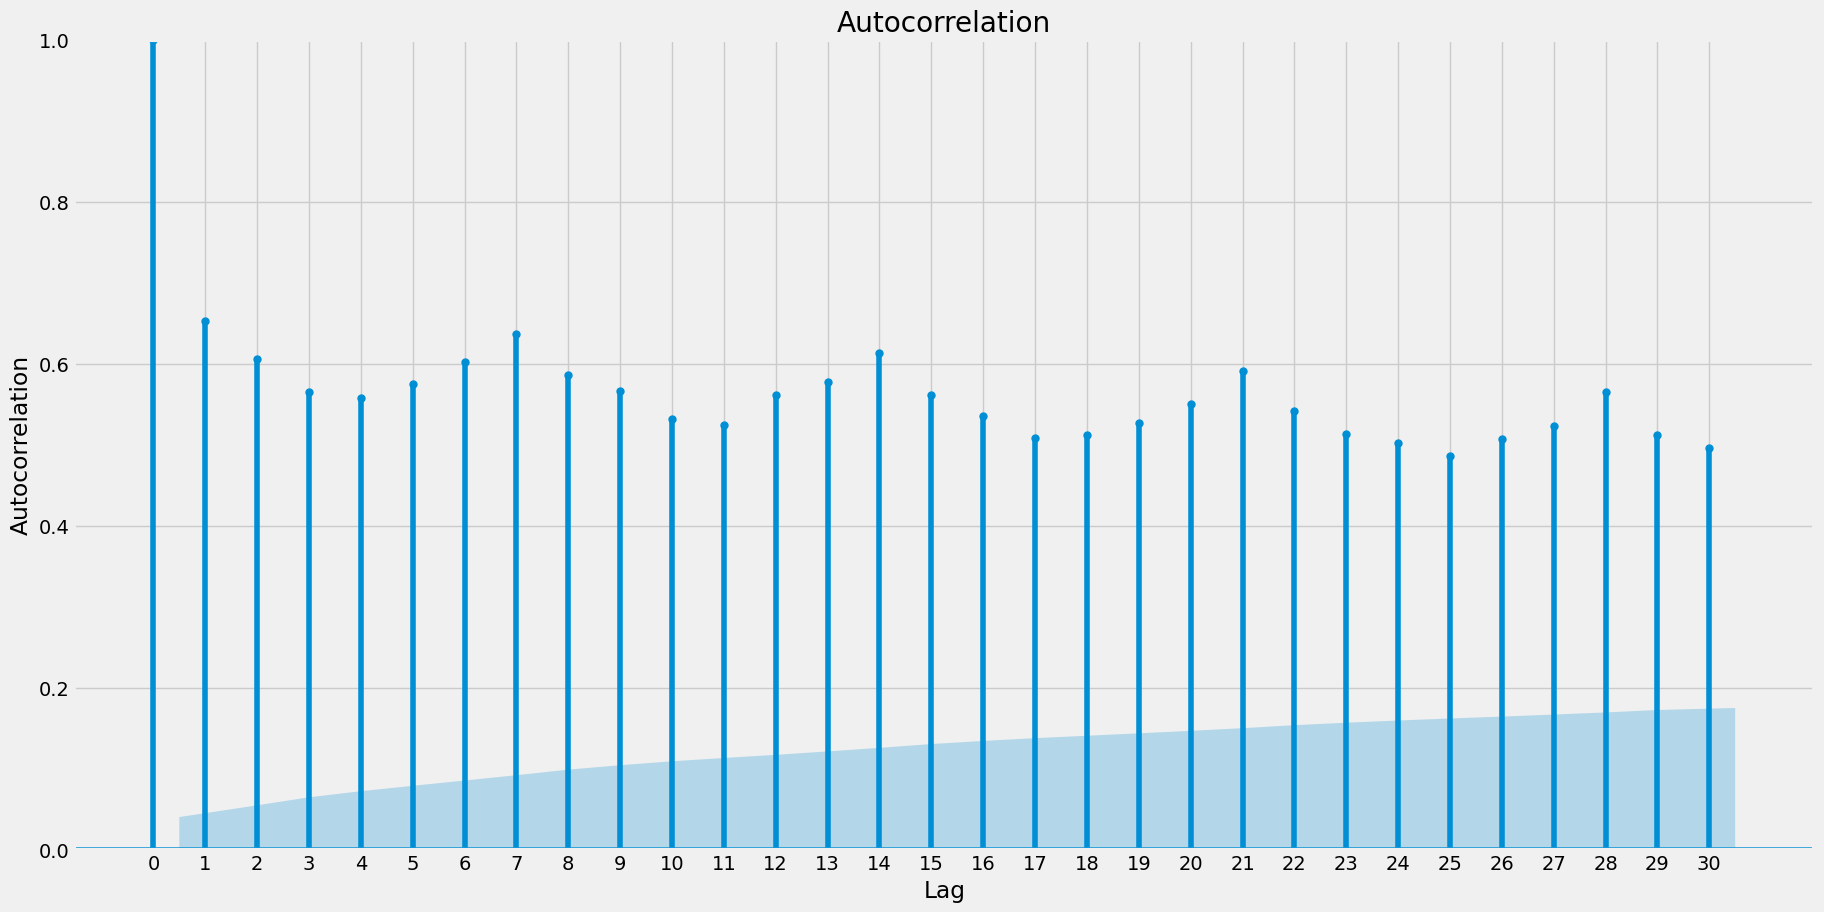

In [24]:
from statsmodels.graphics.tsaplots import plot_acf

# Plotting the autocorrelation function (ACF) for the daily crime counts with 30 lags

fig, ax = plt.subplots(figsize=(20, 10))
plot_acf(df_top5.groupby('incident_date')['count'].sum().reset_index()['count'], lags=30, ax=ax)

plt.ylim(0, 1)
plt.xticks(range(0, 31))


ax.set_xlabel('Lag')
ax.set_ylabel('Autocorrelation')

plt.show();

In [25]:
# Categorizing 'min_temperature' into 'low', 'medium', and 'high' bins and renaming the column
df_top5.min_temperature = pd.cut(df_top5.min_temperature, bins=3, labels=['low', 'medium', 'high'])
df_top5.rename(columns={'min_temperature':'temperature'}, inplace=True)

In [26]:
# Cleaning and converting 'holiday_type' column to categorical type after removing ' (observed)'
df_top5.holiday_type = df_top5.holiday_type.astype('object')
df_top5.holiday_type = df_top5.holiday_type.str.replace(' (observed)', '').astype('category')
df_top5.holiday_type.cat.categories

Index(['Christmas Day', 'Columbus Day', 'Independence Day',
       'Juneteenth National Independence Day', 'Labor Day',
       'Martin Luther King Jr. Day', 'Memorial Day', 'New Year's Day',
       'Thanksgiving', 'Veterans Day', 'Washington's Birthday', 'no_holiday',
       'pride_day'],
      dtype='object')

In [27]:
# Converting 'incident_date' to datetime, extracting month and weekday, and setting 'incident_date' as index
df_top5['incident_date'] = pd.to_datetime(df_top5['incident_date'])


df_top5['month'] = df_top5['incident_date'].dt.month
df_top5['month'] = df_top5['month'].replace({1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
                                           7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'})


df_top5['weekday'] = df_top5['incident_date'].dt.weekday
df_top5['weekday'] = df_top5['weekday'].replace({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})


df_top5.set_index('incident_date', inplace=True)

df_top5.head(2)

,neighborhood_label,subcategory,count,precipitation,temperature,holiday_type,month,weekday
incident_date,,,,,,,,
2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday
2018-01-01,0,Larceny Theft - Other,3,No Rain,low,New Year's Day,January,Monday


<Axes: xlabel='year'>

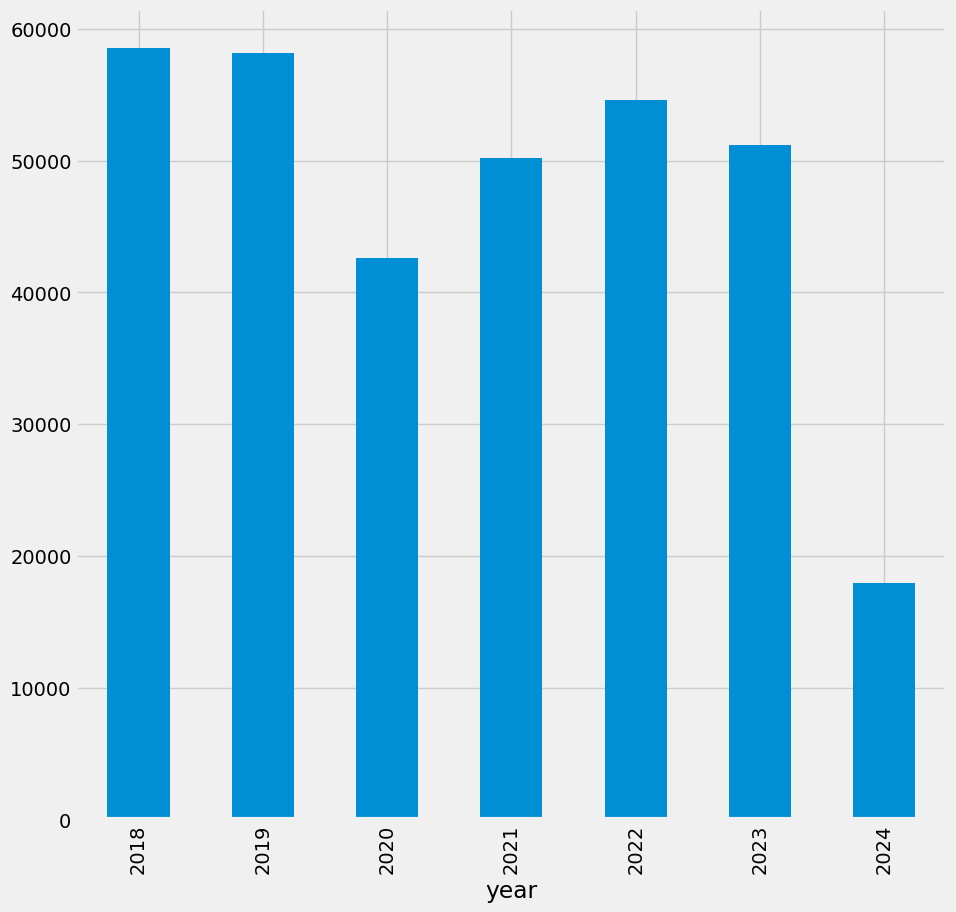

In [28]:
df_top5['year'] = df_top5.index.year
df_top5.groupby('year')['count'].sum().plot(kind='bar', figsize=(10,10))

# 2020 appears anomalous due to the impact of the COVID-19 shutdown

In [29]:
# Removing data for the year 2020 and dropping the 'year' column
df_top5 = df_top5.query('year != 2020')
df_top5.drop(columns=['year'], inplace=True)

In [30]:
# Calculating previous day's and previous week's incident counts, filling missing values with averages, and saving the updated dataframe
df_top5 = df_top5.reset_index()
df_top5.loc[:, 'prev_7_days_count'] = np.nan
df_top5.loc[:,'prev_day_count'] = np.nan
if not os.path.exists('./drive/MyDrive/Colab Notebooks/df_top5_updated.csv'):
  for i in (df_top5.incident_date.unique()[:-7] + pd.Timedelta(days=7)):
      pre_day = i - pd.Timedelta(days=1)
      prev_7_days = i - pd.Timedelta(days=7)
      for _, row in df_top5[df_top5.incident_date == i].iterrows():
          neighborhood = row['neighborhood_label']
          category = row['subcategory']
          try:
              df_top5.loc[(df_top5.incident_date == pre_day) & (df_top5.neighborhood_label == neighborhood) & (df_top5.subcategory == category), 'prev_day_count'] = df_top5.loc[(df_top5.incident_date == i) & (df_top5.neighborhood_label == neighborhood) & (df_top5.subcategory == category), 'count'].values
          except:
              pass
          try:
            df_top5.loc[(df_top5.incident_date == prev_7_days) & (df_top5.neighborhood_label == neighborhood) & (df_top5.subcategory == category), 'prev_7_days_count'] = df_top5.loc[(df_top5.incident_date == i) & (df_top5.neighborhood_label == neighborhood) & (df_top5.subcategory == category), 'count'].values
          except:
              pass

  average_count = df_top5.groupby(['neighborhood_label', 'subcategory', 'weekday'])['count'].mean().astype(int)
  df_top5.prev_day_count.fillna(df_top5.apply(lambda x: average_count[x['neighborhood_label'], x['subcategory'], x['weekday']], axis=1), inplace=True)
  df_top5.prev_7_days_count.fillna(df_top5.apply(lambda x: average_count[x['neighborhood_label'], x['subcategory'], x['weekday']], axis=1), inplace=True)
  df_top5.to_csv('./drive/MyDrive/Colab Notebooks/df_top5_updated.csv')

In [31]:
df_top5 = pd.read_csv('./drive/MyDrive/Colab Notebooks/df_top5_updated.csv')

In [32]:
# Dropping unnecessary column and converting selected columns to categorical types
df_top5.drop(columns=['Unnamed: 0'], inplace=True)
df_top5 = df_top5.astype({'neighborhood_label':'category', 'subcategory':'category', 'holiday_type':'category', 'precipitation':'category', 'temperature':'category', 'month':'category', 'weekday':'category'})
df_top5.incident_date = pd.to_datetime(df_top5.incident_date)
df_top5.head()

,incident_date,neighborhood_label,subcategory,count,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0
1,2018-01-01,0,Larceny Theft - Other,3,No Rain,low,New Year's Day,January,Monday,3.0,2.0
2,2018-01-01,0,Motor Vehicle Theft,1,No Rain,low,New Year's Day,January,Monday,1.0,1.0
3,2018-01-01,0,Vandalism,3,No Rain,low,New Year's Day,January,Monday,2.0,2.0
4,2018-01-01,1,Larceny - From Vehicle,3,No Rain,low,New Year's Day,January,Monday,1.0,1.0


In [33]:
# Filtering data for top 5 subcategories and assigning neighborhood labels using KMeans
df_hourly = df[df['subcategory'].isin(top5_subcat)]
df_hourly['subcategory'] = df_hourly['subcategory'].astype('object').astype('category')
df_hourly['neighborhood_label'] = kmeans.predict(df_hourly[['latitude', 'longitude']])
df_hourly.head()

,incident_time,incident_year,incident_day,incident_no,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger,is_holiday,holiday_type,pride_day,neighborhood_label,incident_hour
incident_date,,,,,,,,,,,,,,,,,,,,
2018-01-01,00:55,2018,Monday,180000172,Assault,Simple Assault,Battery,Mission,37.768473,-122.405828,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,14,0
2018-01-01,16:30,2018,Monday,186000005,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Mission,37.761268,-122.416797,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,8,16
2018-01-01,19:00,2018,Monday,180002225,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Russian Hill,37.802201,-122.417966,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,0,19
2018-01-01,17:00,2018,Monday,180002281,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Russian Hill,37.805287,-122.423655,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,0,17
2018-01-01,01:00,2018,Monday,186009552,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Hayes Valley,37.774858,-122.427631,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,8,1


In [34]:
# Combining incident date and time into a single datetime column and resetting the index
df_hourly.reset_index(inplace=True)
df_hourly.incident_date = df_hourly.incident_date.astype(str) + ' ' + df_hourly.incident_time.astype(str)
df_hourly.incident_date = pd.to_datetime(df_hourly.incident_date)
df_hourly.set_index('incident_date', inplace=True)
df_hourly.head()

,incident_time,incident_year,incident_day,incident_no,category,subcategory,description,neighborhood,latitude,longitude,precipitation,min_temperature,max_temperature,deplaned_passenger,enplaned_passenger,is_holiday,holiday_type,pride_day,neighborhood_label,incident_hour
incident_date,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:55:00,00:55,2018,Monday,180000172,Assault,Simple Assault,Battery,Mission,37.768473,-122.405828,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,14,0
2018-01-01 16:30:00,16:30,2018,Monday,186000005,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Mission,37.761268,-122.416797,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,8,16
2018-01-01 19:00:00,19:00,2018,Monday,180002225,Larceny Theft,Larceny - From Vehicle,"Theft, From Locked Vehicle, >$950",Russian Hill,37.802201,-122.417966,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,0,19
2018-01-01 17:00:00,17:00,2018,Monday,180002281,Vandalism,Vandalism,"Malicious Mischief, Vandalism to Property",Russian Hill,37.805287,-122.423655,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,0,17
2018-01-01 01:00:00,01:00,2018,Monday,186009552,Larceny Theft,Larceny Theft - Other,"Theft, Other Property, $50-$200",Hayes Valley,37.774858,-122.427631,0.0,48.0,61.0,2172552.0,2016637.0,True,New Year's Day,0,8,1


In [35]:
df_hourly = df_hourly[['incident_year', 'incident_time', 'subcategory', 'neighborhood_label', 'incident_hour']]
df_hourly = df_hourly[df_hourly['incident_year'] != 2020]
df_hourly.head()

,incident_year,incident_time,subcategory,neighborhood_label,incident_hour
incident_date,,,,,
2018-01-01 00:55:00,2018,00:55,Simple Assault,14,0
2018-01-01 16:30:00,2018,16:30,Vandalism,8,16
2018-01-01 19:00:00,2018,19:00,Larceny - From Vehicle,0,19
2018-01-01 17:00:00,2018,17:00,Vandalism,0,17
2018-01-01 01:00:00,2018,01:00,Larceny Theft - Other,8,1


In [36]:
hourly_crime_counts = df_hourly.groupby(['neighborhood_label', pd.Grouper(freq='H'), 'subcategory'])['incident_time'].count().unstack(fill_value=0)
hourly_crime_counts

subcategory                             Larceny - From Vehicle  \
neighborhood_label incident_date                                 
0                  2018-01-01 00:00:00                       0   
                   2018-01-01 01:00:00                       1   
                   2018-01-01 02:00:00                       0   
                   2018-01-01 03:00:00                       0   
                   2018-01-01 04:00:00                       0   
...                                                        ...   
14                 2024-07-09 18:00:00                       0   
                   2024-07-09 19:00:00                       0   
                   2024-07-09 20:00:00                       0   
                   2024-07-09 21:00:00                       0   
                   2024-07-09 22:00:00                       0   

subcategory                             Larceny Theft - Other  \
neighborhood_label incident_date                                
0                  2018-01-01 00:00:00                      1   
                   2018-01-01 01:00:00                      0   
                   2018-01-01 02:00:00                      0   
                   2018-01-01 03:00:00                      0   
                   2018-01-01 04:00:00                      0   
...                                                       ...   
14                 2024-07-09 18:00:00                      0   
                   2024-07-09 19:00:00                      0   
                   2024-07-09 20:00:00                      0   
                   2024-07-09 21:00:00                      0   
                   2024-07-09 22:00:00                      0   

subcategory                             Motor Vehicle Theft  Simple Assault  \
neighborhood_label incident_date                                              
0                  2018-01-01 00:00:00                    0               0   
                   2018-01-01 01:00:00                    0               0   
                   2018-01-01 02:00:00                    0               0   
                   2018-01-01 03:00:00                    0               0   
                   2018-01-01 04:00:00                    0               0   
...                                                     ...             ...   
14                 2024-07-09 18:00:00                    0               0   
                   2024-07-09 19:00:00                    0               0   
                   2024-07-09 20:00:00                    0               0   
                   2024-07-09 21:00:00                    0               0   
                   2024-07-09 22:00:00                    0               0   

subcategory                             Vandalism  
neighborhood_label incident_date                   
0                  2018-01-01 00:00:00          0  
                   2018-01-01 01:00:00          0  
                   2018-01-01 02:00:00          0  
                   2018-01-01 03:00:00          0  
                   2018-01-01 04:00:00          0  
...                                           ...  
14                 2024-07-09 18:00:00          0  
                   2024-07-09 19:00:00          0  
                   2024-07-09 20:00:00          0  
                   2024-07-09 21:00:00          0  
                   2024-07-09 22:00:00          0  

[857505 rows x 5 columns]

In [37]:
# Get the neighborhood labels from the first level of the index
neighborhood_labels = hourly_crime_counts.index.get_level_values(0)

# Get the hour of the day from the second level of the index (which is a DateTimeIndex)
hours = hourly_crime_counts.index.get_level_values(1).hour

# Group by neighborhood label and hour and sum across subcategories
result = hourly_crime_counts.groupby([neighborhood_labels, hours])[hourly_crime_counts.columns].sum()


result.head()

subcategory                       Larceny - From Vehicle  \
neighborhood_label incident_date                           
0                  0                                 309   
                   1                                 198   
                   2                                 142   
                   3                                  95   
                   4                                  88   

subcategory                       Larceny Theft - Other  Motor Vehicle Theft  \
neighborhood_label incident_date                                               
0                  0                                179                   66   
                   1                                 92                   34   
                   2                                 41                   24   
                   3                                 21                   14   
                   4                                 29                   16   

subcategory                       Simple Assault  Vandalism  
neighborhood_label incident_date                             
0                  0                          69        117  
                   1                          57         89  
                   2                          54         69  
                   3                          16         81  
                   4                          10         63

In [38]:
# Normalizing the values in the dataframe by column-wise sum for the first two rows and then for all rows
result.loc[0:1, :][result.columns[0]] = result.loc[0:1, :][result.columns[0]] / result.loc[0:1, :][result.columns[0]].sum()
for n in range(15):
  for category in range(len(result.columns)):
    result.iloc[:, category][n] =  result.iloc[:, category][n] /  result.iloc[:, category][n].sum()
result

subcategory                       Larceny - From Vehicle  \
neighborhood_label incident_date                           
0                  0                            0.015913   
                   1                            0.010197   
                   2                            0.007313   
                   3                            0.004892   
                   4                            0.004532   
...                                                  ...   
14                 19                           0.095002   
                   20                           0.081945   
                   21                           0.064836   
                   22                           0.057857   
                   23                           0.044575   

subcategory                       Larceny Theft - Other  Motor Vehicle Theft  \
neighborhood_label incident_date                                               
0                  0                           0.058727             0.044444   
                   1                           0.030184             0.022896   
                   2                           0.013451             0.016162   
                   3                           0.006890             0.009428   
                   4                           0.009514             0.010774   
...                                                 ...                  ...   
14                 19                          0.052756             0.052229   
                   20                          0.041922             0.059448   
                   21                          0.034385             0.057325   
                   22                          0.025436             0.060722   
                   23                          0.025436             0.043737   

subcategory                       Simple Assault  Vandalism  
neighborhood_label incident_date                             
0                  0                    0.058376   0.035956  
                   1                    0.048223   0.027351  
                   2                    0.045685   0.021205  
                   3                    0.013536   0.024892  
                   4                    0.008460   0.019361  
...                                          ...        ...  
14                 19                   0.052930   0.060907  
                   20                   0.050095   0.058747  
                   21                   0.043478   0.058747  
                   22                   0.058601   0.044492  
                   23                   0.042533   0.046220  

[360 rows x 5 columns]

In [39]:
df_hourly.head(1)

,incident_year,incident_time,subcategory,neighborhood_label,incident_hour
incident_date,,,,,
2018-01-01 00:55:00,2018,00:55,Simple Assault,14,0


In [40]:
df_hourly.index = pd.to_datetime(df_hourly.index).date
df_hourly.head()

,incident_year,incident_time,subcategory,neighborhood_label,incident_hour
2018-01-01,2018,00:55,Simple Assault,14,0
2018-01-01,2018,16:30,Vandalism,8,16
2018-01-01,2018,19:00,Larceny - From Vehicle,0,19
2018-01-01,2018,17:00,Vandalism,0,17
2018-01-01,2018,01:00,Larceny Theft - Other,8,1


In [41]:
df_hourly.reset_index(inplace=True)
df_hourly.drop(columns=['incident_time', 'incident_year'], inplace=True)
df_hourly.head()

,index,subcategory,neighborhood_label,incident_hour
0,2018-01-01,Simple Assault,14,0
1,2018-01-01,Vandalism,8,16
2,2018-01-01,Larceny - From Vehicle,0,19
3,2018-01-01,Vandalism,0,17
4,2018-01-01,Larceny Theft - Other,8,1


In [42]:
df_hourly.rename(columns={'index':'incident_date'}, inplace=True)
df_hourly.head()

,incident_date,subcategory,neighborhood_label,incident_hour
0,2018-01-01,Simple Assault,14,0
1,2018-01-01,Vandalism,8,16
2,2018-01-01,Larceny - From Vehicle,0,19
3,2018-01-01,Vandalism,0,17
4,2018-01-01,Larceny Theft - Other,8,1


In [43]:
df_top5.head()

,incident_date,neighborhood_label,subcategory,count,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0
1,2018-01-01,0,Larceny Theft - Other,3,No Rain,low,New Year's Day,January,Monday,3.0,2.0
2,2018-01-01,0,Motor Vehicle Theft,1,No Rain,low,New Year's Day,January,Monday,1.0,1.0
3,2018-01-01,0,Vandalism,3,No Rain,low,New Year's Day,January,Monday,2.0,2.0
4,2018-01-01,1,Larceny - From Vehicle,3,No Rain,low,New Year's Day,January,Monday,1.0,1.0


In [44]:
df_daily = df_top5
del(df_top5)
df_hourly = df_hourly.groupby(['incident_date', 'incident_hour', 'neighborhood_label', 'subcategory']).size().reset_index().rename(columns={0:'count'})

In [45]:
result.reset_index(inplace=True)
result.head()

subcategory,neighborhood_label,incident_date,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism
0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956
1,0,1,0.010197,0.030184,0.022896,0.048223,0.027351
2,0,2,0.007313,0.013451,0.016162,0.045685,0.021205
3,0,3,0.004892,0.006890,0.009428,0.013536,0.024892
4,0,4,0.004532,0.009514,0.010774,0.008460,0.019361


In [46]:
#  Merge the DataFrames
df_daily.incident_date = pd.to_datetime(df_daily.incident_date)
df_hourly.incident_date = pd.to_datetime(df_hourly.incident_date)
df_merged = pd.merge(df_daily, df_hourly, on=['incident_date', 'neighborhood_label', 'subcategory'])

# Rename columns for clarity
df_merged.rename(columns={'count_x': 'day_total', 'count_y': 'hour_total'}, inplace=True)



In [47]:
result.rename(columns={'incident_date':'incident_hour'}, inplace=True)
result.head()

subcategory,neighborhood_label,incident_hour,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism
0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956
1,0,1,0.010197,0.030184,0.022896,0.048223,0.027351
2,0,2,0.007313,0.013451,0.016162,0.045685,0.021205
3,0,3,0.004892,0.006890,0.009428,0.013536,0.024892
4,0,4,0.004532,0.009514,0.010774,0.008460,0.019361


In [69]:
df_merged_ = pd.merge(df_merged, result, on=['neighborhood_label', 'incident_hour'], how='left')
df_merged_.head()

,incident_date,neighborhood_label,subcategory,day_total,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count,incident_hour,hour_total,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956
1,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,1,1,0.010197,0.030184,0.022896,0.048223,0.027351
2,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,2,0,0.007313,0.013451,0.016162,0.045685,0.021205
3,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,3,0,0.004892,0.006890,0.009428,0.013536,0.024892
4,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,4,0,0.004532,0.009514,0.010774,0.008460,0.019361


In [70]:
# Remove the row corresponding to the incident on 2023-08-12 (Outsideland Music Festival) due to outlier behavior
df_merged_  = df_merged_[df_merged_.incident_date != '2023-08-12']

In [50]:

X = df_merged_[['neighborhood_label', 'subcategory', 'weekday', 'precipitation', 'temperature','holiday_type', 'month', 'prev_7_days_count', 'prev_day_count']]


In [51]:
X = X.iloc[0::24]
y = df_merged_['day_total'][0::24]

In [52]:
from sklearn.preprocessing import OneHotEncoder


categorical_features = ['neighborhood_label', 'subcategory', 'weekday', 'precipitation', 'temperature', 'holiday_type', 'month']
numerical_features = ['prev_7_days_count', 'prev_day_count']


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ],
    remainder='passthrough' )


X_encoded = preprocessor.fit_transform(X)



XGBoost Regressor
MSE:  4.31104033970276
MAE:  1.2382468911131332
R2:  0.596494197845459


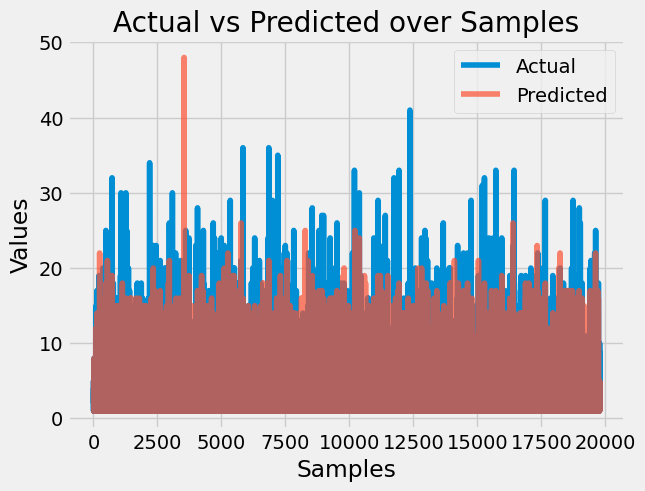

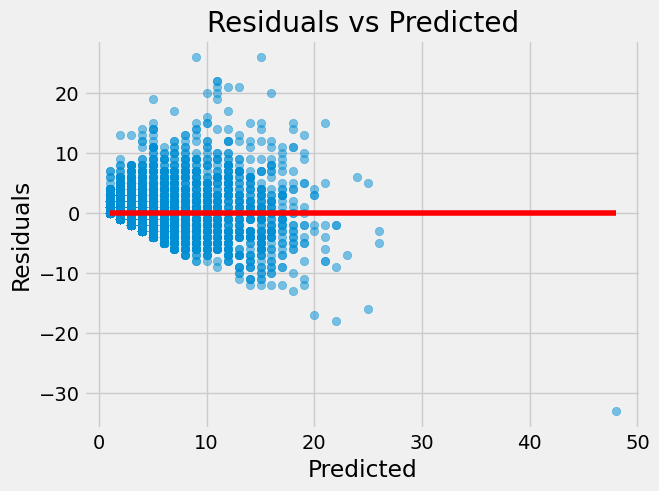

In [53]:


from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score


X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

model = XGBRegressor(random_state=0)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred = np.round(y_pred)
print('XGBoost Regressor')
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted over Samples')
plt.legend()
plt.show()


residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()


# R2:  0.596494197845459, this score is quite good. Most probably we will continue with XGBoost model

In [54]:
import joblib
if not os.path.exists('./drive/MyDrive/Colab Notebooks/modelNN.joblib'):
  modelNN = keras.Sequential([
      layers.Dense(128, activation='relu', input_shape=[X_encoded.shape[1]]),
      layers.Dense(64, activation='relu'),
      layers.Dense(1, activation='exponential')
  ])

  modelNN.compile(loss='mean_squared_error', optimizer='adam')



  modelNN.fit(X_train.toarray(), y_train, epochs=100, batch_size=16)
  joblib.dump(modelNN, './drive/MyDrive/Colab Notebooks/modelNN.joblib')

In [55]:
modelNN = joblib.load('./drive/MyDrive/Colab Notebooks/modelNN.joblib')
y_pred = modelNN.predict(X_test)

print('Neural Network')
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Neural Network
MSE:  4.574288358246164
MAE:  1.2955168448430006
R2:  0.5718546509742737


619/619 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Neural Network
MSE:  4.66206652512385
MAE:  1.2694874127995146
R2:  0.5636388063430786


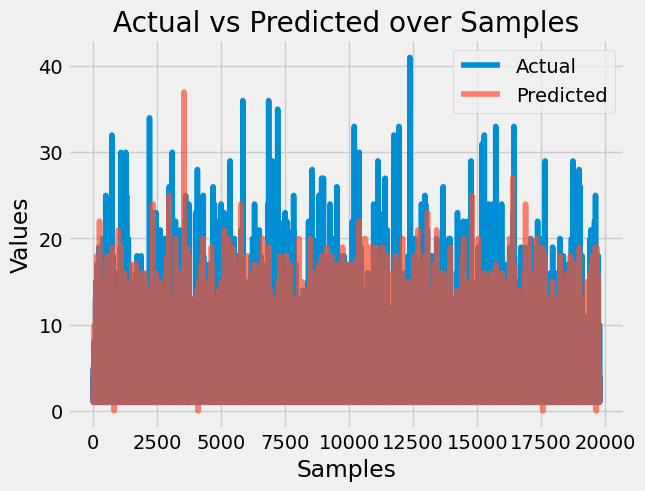

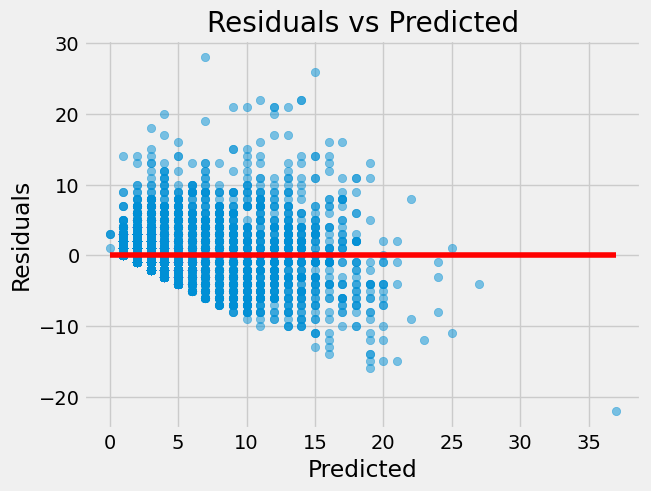

In [56]:
y_pred = modelNN.predict(X_test).ravel()
y_pred = np.round(y_pred)
print('Neural Network')
print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Actual vs Predicted over Samples')
plt.legend()
plt.show()


residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.hlines(0, y_pred.min(), y_pred.max(), colors='red')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.show()

We go with XGBoost Regressor

In [57]:
X.head()

,neighborhood_label,subcategory,weekday,precipitation,temperature,holiday_type,month,prev_7_days_count,prev_day_count
0,0,Larceny - From Vehicle,Monday,No Rain,low,New Year's Day,January,10.0,10.0
24,0,Larceny Theft - Other,Monday,No Rain,low,New Year's Day,January,3.0,2.0
48,0,Motor Vehicle Theft,Monday,No Rain,low,New Year's Day,January,1.0,1.0
72,0,Vandalism,Monday,No Rain,low,New Year's Day,January,2.0,2.0
96,1,Larceny - From Vehicle,Monday,No Rain,low,New Year's Day,January,1.0,1.0


In [58]:
y_pred_all = model.predict(X_encoded)
y_pred_all = np.round(y_pred_all)
df_merged_.head(1)

,incident_date,neighborhood_label,subcategory,day_total,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count,incident_hour,hour_total,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956


In [59]:
X['day_total_predicted'] = y_pred_all

In [71]:
df_merged_ = pd.merge(df_merged_, X[['day_total_predicted']], left_index=True, right_index=True, how='left')
df_merged_.head()

,incident_date,neighborhood_label,subcategory,day_total,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count,incident_hour,hour_total,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism,day_total_predicted
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956,11.0
1,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,1,1,0.010197,0.030184,0.022896,0.048223,0.027351,NaN
2,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,2,0,0.007313,0.013451,0.016162,0.045685,0.021205,NaN
3,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,3,0,0.004892,0.006890,0.009428,0.013536,0.024892,NaN
4,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,4,0,0.004532,0.009514,0.010774,0.008460,0.019361,NaN


In [72]:
df_merged_.day_total_predicted = df_merged_.day_total_predicted.fillna(method='ffill')


In [62]:
df_merged_.head()

,incident_date,neighborhood_label,subcategory,day_total,precipitation,temperature,holiday_type,month,weekday,prev_7_days_count,prev_day_count,incident_hour,hour_total,Larceny - From Vehicle,Larceny Theft - Other,Motor Vehicle Theft,Simple Assault,Vandalism,day_total_predicted
0,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,0,0,0.015913,0.058727,0.044444,0.058376,0.035956,11.0
1,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,1,1,0.010197,0.030184,0.022896,0.048223,0.027351,11.0
2,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,2,0,0.007313,0.013451,0.016162,0.045685,0.021205,11.0
3,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,3,0,0.004892,0.006890,0.009428,0.013536,0.024892,11.0
4,2018-01-01,0,Larceny - From Vehicle,12,No Rain,low,New Year's Day,January,Monday,10.0,10.0,4,0,0.004532,0.009514,0.010774,0.008460,0.019361,11.0


In [63]:
def get_coefficient(row):
    """Returns the coefficient for the given row based on its subcategory."""
    subcategory = row['subcategory']
    return row[f'{subcategory}']  # Dynamically access the column


In [73]:
df_merged_['ratio'] = df_merged_.apply(get_coefficient, axis=1)



In [74]:
df_merged_['hourly_predicted'] = 0

In [75]:
# Simulate hourly predicted counts for each day based on the given hourly ratios and total events
for i in range(0, len(df_merged_), 24):
    total_events = int(df_merged_.iloc[i]['day_total'])
    hour_probabilities = df_merged_.iloc[i:i+24]['ratio'].values

    # Randomly choose hours for the total events based on the hourly probabilities
    chosen_hours = np.random.choice(24, size=total_events, p=hour_probabilities)
    chosen_hours = np.bincount(chosen_hours, minlength=24)

    df_merged_.iloc[i:i+24, -1] = chosen_hours




MSE:  0.25303149792058455
MAE:  0.19450707405684858


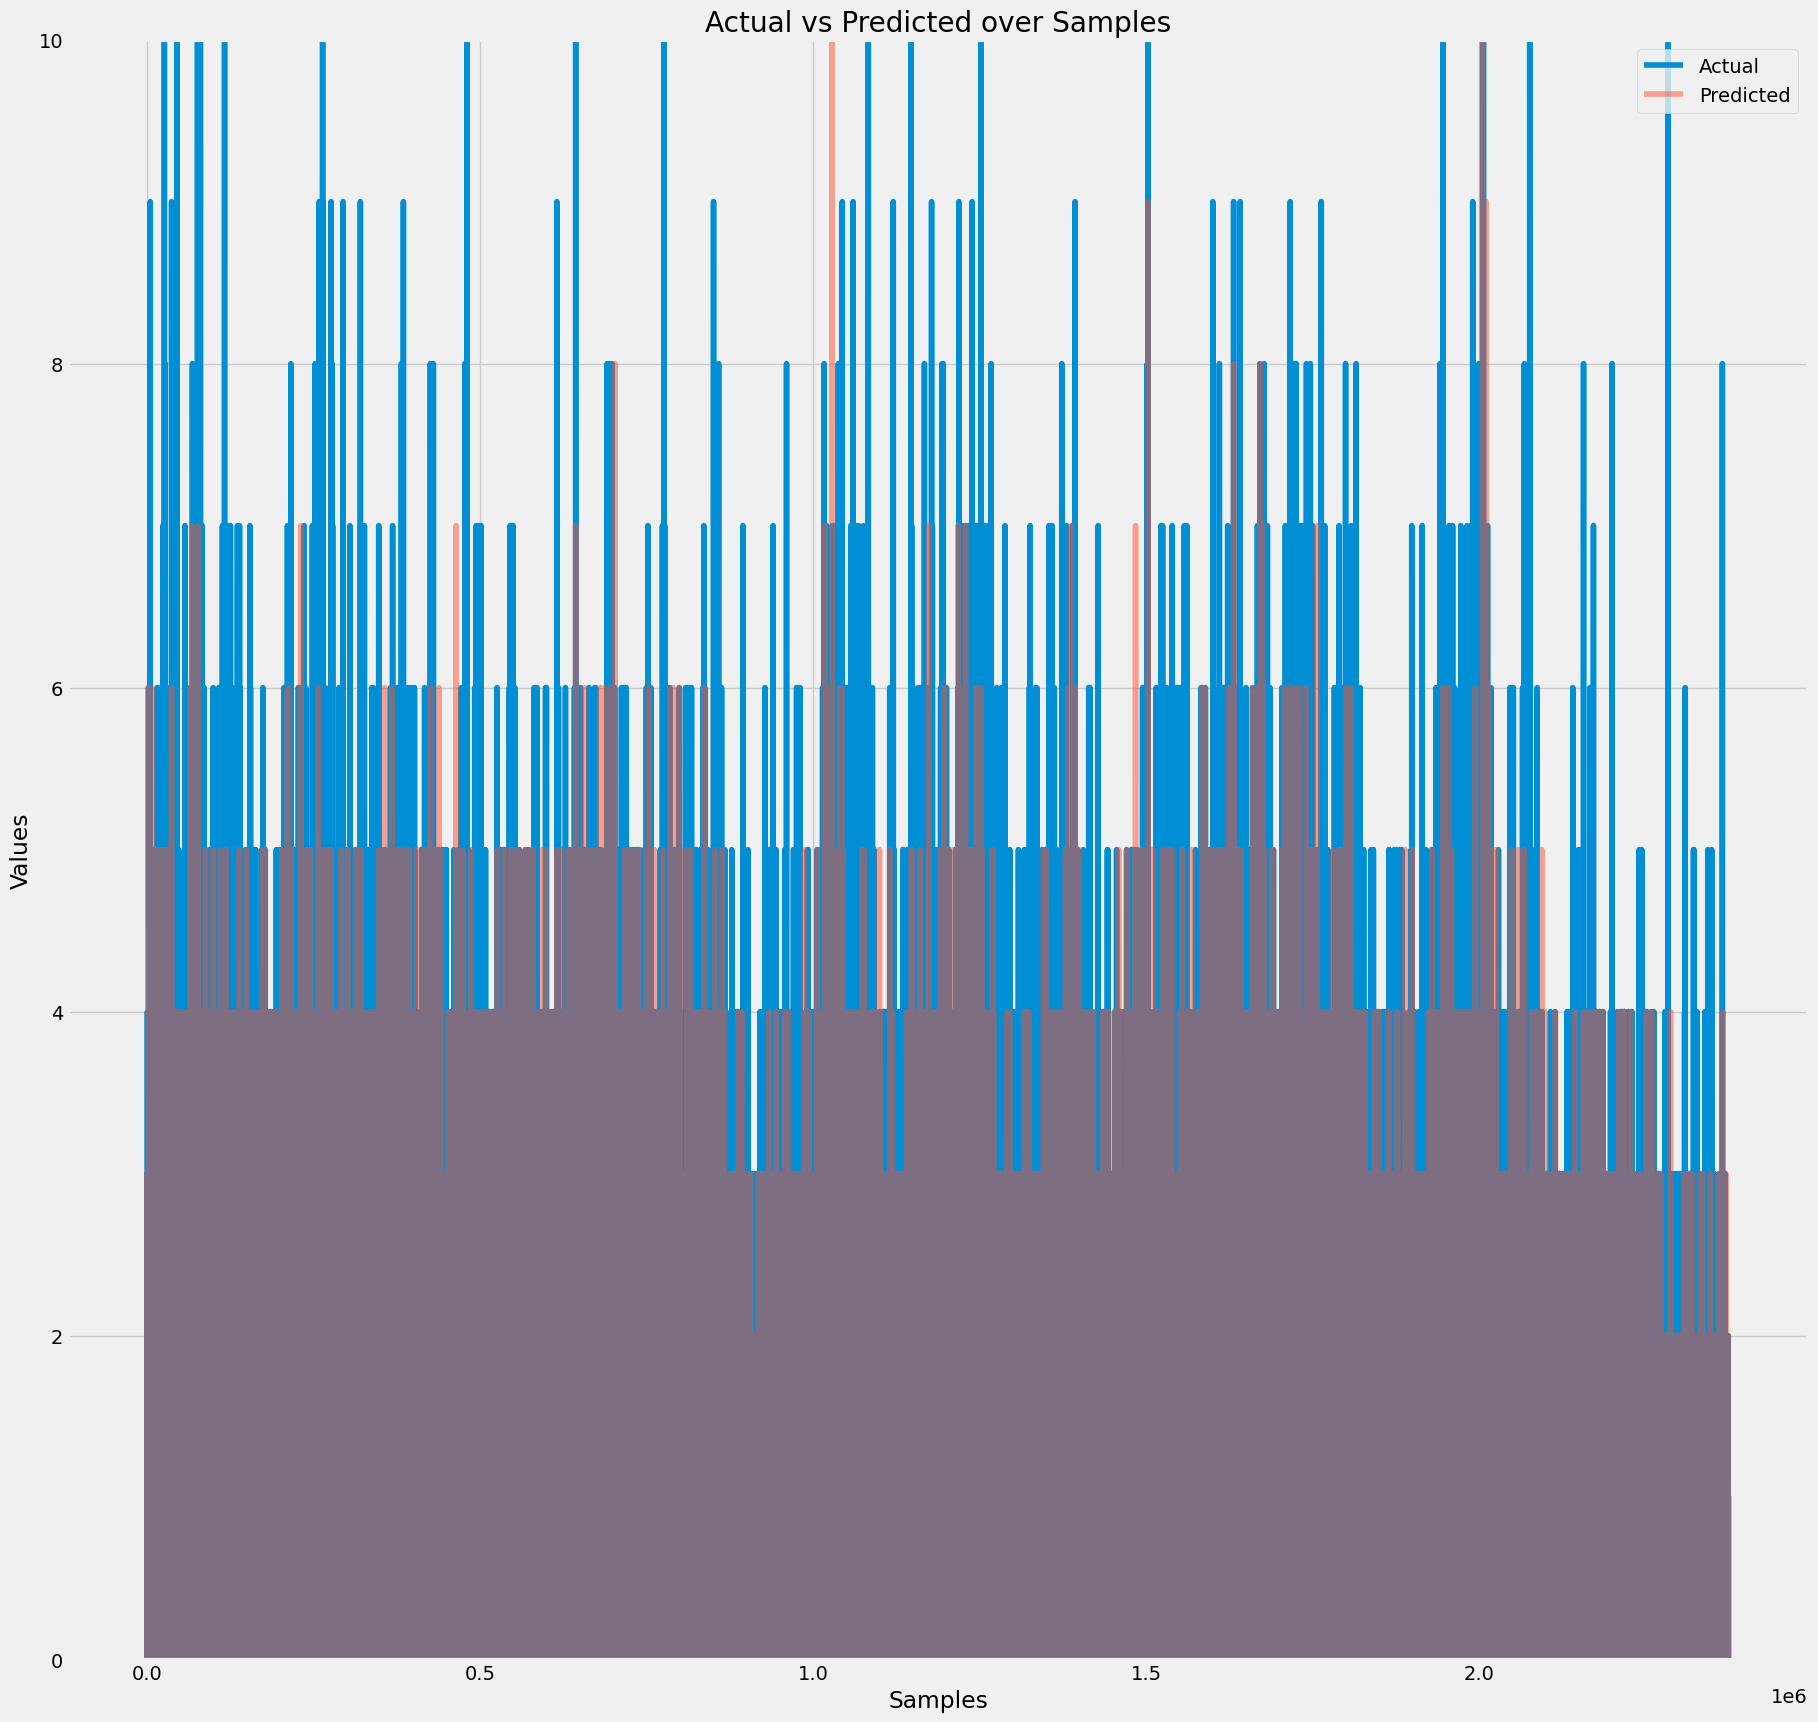

In [76]:
y_test = df_merged_.hour_total
y_pred = df_merged_.hourly_predicted

print('MSE: ', mean_squared_error(y_test, y_pred))
print('MAE: ', mean_absolute_error(y_test, y_pred))

plt.figure(figsize=(20, 20))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted', alpha=0.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.ylim(0,10)
plt.title('Actual vs Predicted over Samples')
plt.legend()
plt.show()



In [78]:
df_merged_.to_csv('./drive/MyDrive/Colab Notebooks/df_merged_.csv')